In [1]:
# This notebook will 
# take in two videos, 
# get the landmarks/keypoints for each frame,
# calculate the difference between each corresponding pair
# calculate the mean square error for all of them

# This notebook will also display two videos side by side with a graph of the keypoint error differences.

In [112]:
import moviepy
from moviepy.editor import *
import pygame
from moviepy.decorators import apply_to_audio, apply_to_mask

from matplotlib import pyplot as plt
import mediapipe as mp
from urllib import request
import os
import pathlib
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
import math

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [26]:
WORKING_DIR = pathlib.Path().resolve()
WORKING_DIR

WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021')

In [32]:
def get_input_filenames(name, base_names):
    """appends the name of the person onto the base file name for poses"""
    new_frames_fnames = []

    for fname in base_names:
        splitname = fname.split(".")
        splitname[0] += ("_"+ name)
        new_name = ".".join(splitname)
        if str(1) in new_name or str(2) in new_name or str(3) in new_name:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_1_3")
            full_path = Path.joinpath(video_path, new_name)
        else:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_4_6")
            full_path = Path.joinpath(video_path, new_name)
            
        new_frames_fnames.append(full_path)

    return new_frames_fnames

In [56]:
def get_filenames():

    teacher_video_fnames = ["pose_1.mp4", "pose_2.mp4", "pose_3.mp4",
                             "pose_4.mp4", "pose_5.mp4", "pose_6.mp4"]
    
    #teacher_video_fpaths = [Path("pose_1_3/pose_1.mp4"), Path("pose_1_3/pose_2.mp4"), Path("pose_1_3/pose_3.mp4"),
    #                       Path("pose_4_6/pose_4.mp4"), Path("pose_4_6/pose_5.mp4"), Path("pose_4_6/pose_6.mp4")]
    teacher_video_fpaths = []
    
    for x in teacher_video_fnames:
        if str(1) in x or str(2) in x or str(3) in x:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_1_3")
            full_path = Path.joinpath(video_path, x)
        else:
            video_path = Path.joinpath(pathlib.Path().resolve(), "pose_4_6")
            full_path = Path.joinpath(video_path, x)
        teacher_video_fpaths.append(full_path)
            

    lori_video_fnames = get_input_filenames("lori", teacher_frames_fnames)

    mikaela_video_fnames = get_input_filenames("mikaela", teacher_frames_fnames)

    jong_video_fnames = get_input_filenames("jong", teacher_frames_fnames)

    return {"teacher": teacher_video_fpaths, 
            "lori": lori_video_fnames,
            "mikaela": mikaela_video_fnames,
            "jong": jong_video_fnames}

video_fpaths = get_filenames()

In [59]:
video_fpaths

{'teacher': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_4.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_5.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_4_6/pose_6.mp4')],
 'lori': [WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_1_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_2_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documents/GitHub/feature_engineering_project2021/pose_1_3/pose_3_lori.mp4'),
  WindowsPath('C:/Users/Cooper/Documen

In [2]:
def display_two_videos(video_one, video_two):
    """Displays a video player for two videos to play side by side"""
    pass

In [71]:
def get_num_frames_of_all_videos(video_fpaths):
    """Returns a dataframe of each pose video's number of frames.
    e.x. ['instructor', 'jong', 'lori', 'mikaela']"""
    video_frame_data = []
    
    subjects = list(video_fpaths.keys())
        
    for i in range(6):
        print(f"Processing Video {i+1}/6")
        video_dict = {}
        for subject in subjects:
            clip = VideoFileClip(str(video_fpaths[subject][i]))
            n_frames = clip.reader.nframes
            print(f"Subject: {subject} has {n_frames} frames.")
            
            video_dict[subject] = n_frames
        
        video_frame_data.append(video_dict)
    
    return pd.DataFrame(video_frame_data)

In [72]:
df = get_num_frames_of_all_videos(video_fpaths)
df

Processing Video 1/6
Subject: teacher has 478 frames.
Subject: lori has 337 frames.
Subject: mikaela has 482 frames.
Subject: jong has 309 frames.
Processing Video 2/6
Subject: teacher has 1152 frames.
Subject: lori has 313 frames.
Subject: mikaela has 804 frames.
Subject: jong has 600 frames.
Processing Video 3/6
Subject: teacher has 229 frames.
Subject: lori has 195 frames.
Subject: mikaela has 207 frames.
Subject: jong has 158 frames.
Processing Video 4/6
Subject: teacher has 379 frames.
Subject: lori has 165 frames.
Subject: mikaela has 275 frames.
Subject: jong has 290 frames.
Processing Video 5/6
Subject: teacher has 370 frames.
Subject: lori has 220 frames.
Subject: mikaela has 380 frames.
Subject: jong has 181 frames.
Processing Video 6/6
Subject: teacher has 487 frames.
Subject: lori has 295 frames.
Subject: mikaela has 306 frames.
Subject: jong has 469 frames.


,teacher,lori,mikaela,jong
0,478,337,482,309
1,1152,313,804,600
2,229,195,207,158
3,379,165,275,290
4,370,220,380,181
5,487,295,306,469


In [122]:
def get_landmarks_video(input_video, every_nth_percentage = .25):
    """returns a dictionary of {frame_num: [x, y, z...]} 33 coordinates of an input video
       for every nth percentage frame number of the whole clip"""
    
    clip = VideoFileClip(input_video)
    n_frames = clip.reader.nframes
    
    frames_list = []
    
    for frame_num in range(0, n_frames, math.floor(n_frames * every_nth_percentage)):
        
        frame = clip.get_frame(frame_num / clip.fps)
        
        frames_list.append(frame)
        
        # showing the frame with the help of matplotlib
        #plt.imshow(frame, interpolation ='nearest')
        # show
        #plt.show()
    return frames_list

In [123]:
def get_warped_video(input_video, end_time):
    """gets a video and warps it to be the length of end_time"""
    clip = VideoFileClip(input_video)
    n_frames = sum(1 for x in clip.iter_frames())
    print(n_frames)
    
    new_video = moviepy.video.fx.all.speedx(clip, factor = None , final_duration=end_time)
    print(new_video.duration)
    
    return new_video

In [124]:
frames = get_landmarks_video(str(video_fpaths["lori"][0]), .25)

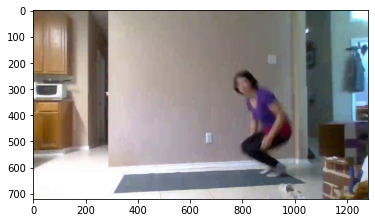

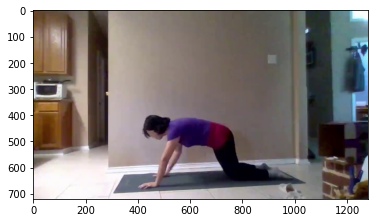

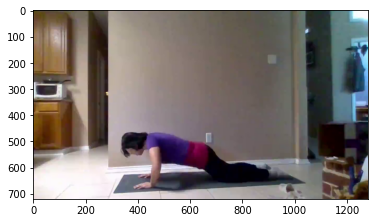

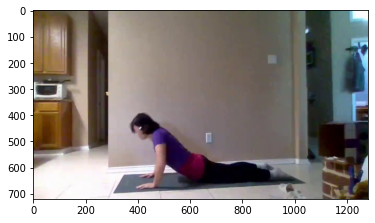

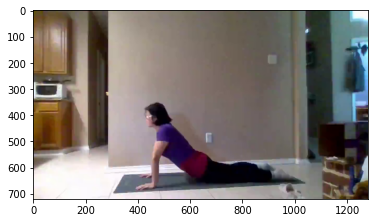

In [126]:
for img in frames:
    plt.imshow(img)
    plt.show()

In [171]:
def get_landmarks(frames_list):
    """returns a dictionary of {frame_num: {landmark 1: [x, y, z]}...} 33 coordinates of an input video
       for every frame number in the frames_list"""
    
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.2, model_complexity=2)
    
    frame_landmarks = []
    for i, img in enumerate(frames_list):
        results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        landmarks = {}
        for j, lmk in enumerate(results.pose_landmarks.landmark):
            landmarks[f"Landmark_{j+1}_X"] = float(lmk.x)
            landmarks[f"Landmark_{j+1}_Y"] = float(lmk.y)
            landmarks[f"Landmark_{j+1}_Z"] = float(lmk.z)
        frame_landmarks.append(landmarks)
        
    return pd.DataFrame(frame_landmarks)

In [172]:
df = get_landmarks(frames)
df

,Landmark_1_X,Landmark_1_Y,Landmark_1_Z,Landmark_2_X,Landmark_2_Y,Landmark_2_Z,Landmark_3_X,Landmark_3_Y,Landmark_3_Z,Landmark_4_X,...,Landmark_30_Z,Landmark_31_X,Landmark_31_Y,Landmark_31_Z,Landmark_32_X,Landmark_32_Y,Landmark_32_Z,Landmark_33_X,Landmark_33_Y,Landmark_33_Z
0,0.626201,0.402757,-0.269756,0.627868,0.384528,-0.268016,0.631542,0.380872,-0.268206,0.634908,...,0.026440,0.737138,0.830570,0.123883,0.714882,0.867468,-0.010464,0.693556,0.864260,0.075988
1,0.368185,0.662363,-0.027049,0.359767,0.646816,-0.049886,0.360452,0.645572,-0.050110,0.361179,...,0.014705,0.686973,0.813152,0.353115,0.762280,0.890151,0.020290,0.720789,0.855002,0.349616
2,0.310162,0.756746,-0.039014,0.300623,0.742831,-0.064310,0.300876,0.739422,-0.064579,0.301270,...,0.152030,0.681231,0.818178,0.424724,0.725536,0.875987,0.136761,0.702374,0.856430,0.413358
3,0.310309,0.646106,-0.016325,0.309991,0.629414,-0.039941,0.311200,0.628319,-0.040202,0.312316,...,0.067717,0.693786,0.816463,0.466744,0.739219,0.940625,-0.006573,0.705127,0.863148,0.438066
4,0.339230,0.568177,0.018607,0.344923,0.552100,-0.000158,0.346584,0.552578,-0.000434,0.347989,...,0.020229,0.704381,0.821202,0.414565,0.759291,0.944842,-0.051222,0.723988,0.864867,0.382990


In [173]:
df.plot(df.Landmark_1_X)

KeyError: "None of [Float64Index([ 0.6262005567550659,  0.3681846857070923, 0.31016185879707336,\n               0.3103090524673462, 0.33923035860061646],\n             dtype='float64')] are in the [columns]"

In [158]:
df["Landmark 1"].values

array([array([ 0.62620056,  0.40275654, -0.26975569]),
       array([ 0.36818469,  0.66236275, -0.02704866]),
       array([ 0.31016186,  0.75674593, -0.03901364]),
       array([ 0.31030905,  0.646106  , -0.01632452]),
       array([0.33923036, 0.56817651, 0.01860691])], dtype=object)

In [104]:
#get_landmarks_video(str(video_fpaths["teacher"][0]), .25)

In [113]:
warped = get_warped_video(str(video_fpaths["lori"][0]), 478)

337
478.0


In [9]:
def graph_rmse(video_keypoints_1, video_keypoints_2):
    """takes in two dictionaries with the {frame_num: [x, y, z...]}
    and graphs the rmse at each frame"""

In [107]:
def crop_videos_to_same_length(input_dir, output_dir):
    """Crop all of the videos in a directory and copies them to a new directory"""
    pass